Project Description

In this project, you need to solve an image classification task using coil-20-proc dataset. This dataset consists of 1,440 grayscale images of 20 objects (72 images per object). Half of each category is for training and half for testing. (e.g. 36 images for training and another 36 images for testing). Through this project, you can learn how to customize dataset loading, design deep models, and train and test models. This is an individual project, so avoid copying others' code. Additionally, you need to print the accuracy results during the training process. You should use a Python Jupyter Notebook to write down the process and accuracy results.


Kowshik Arko Dey
3180300806


# 1. Complete the custom dataset, and dataloader.
Fill in the code to complete the custom dataset and dataloader, you can refer to https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [1]:
#Import all necessary libraries
import glob
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import random
import time
import os
import torch
import torch.nn as nn
import random
from torchvision import transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import argparse
from datetime import datetime
import logging
from tqdm import tqdm
import sys
INDEX = 0

# Create the base dataset class
class Mydataset(Dataset):
    def __init__(self, images, labels, transform):
    # you should complete __init__ function
        #The init function of the base dataset class
        self.images = images
        self.labels = labels
        self.transform = transform
        

    def __getitem__(self, index):
    # you should complete __getitem__ function
        img = Image.open(self.images[index]).convert('L')  # Convert the image to grayscale
        label = self.labels[index]  #Store the labels
        img = self.transform(img)   #Transform each image data according to tranform
        return img, label

    def __len__(self):
    # you should complete __len__ function
        return len(self.images)     #Returns length of dataset

#The load dataset function to load the entire directory
def load_dataset(self):
# you should complete load_dataset function
    
    transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    ])
    data_path = 'coil-20-proc/coil-20-proc/'
    image_paths = []
    labels = []
    

    # Navigate through the subdirectories and collect image paths and labels
    for i in range(1, 21):  # Assuming categories are labeled from 01 to 20
        directory = os.path.join(data_path, f'{i:02}')  # Format subdirectory path
        images_in_dir = glob.glob(f"{directory}/*.png")
        image_paths.extend(images_in_dir)
        labels.extend([i-1] * 72)  # Label is shifted to start from 0 due to Pytorch conventions

    # Shuffle the dataset to ensure randomness
    combined = list(zip(image_paths, labels))
    random.shuffle(combined)
    image_paths[:], labels[:] = zip(*combined)
    
    # Splitting the dataset into train and test
    split_idx = int(len(image_paths) * (1 - 0.5))
    train_paths, test_paths = image_paths[:split_idx], image_paths[split_idx:]
    train_labels, test_labels = labels[:split_idx], labels[split_idx:]


    # Create the dataset objects
    train_dataset = Mydataset(train_paths, train_labels, transform)
    test_dataset = Mydataset(test_paths, test_labels, transform)

    # Create the dataloaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True,pin_memory=True)
    
    return train_loader, test_loader

# 2. Implementing a Neural Network
Fill in the code to complete the custom model, you can refer to https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html

In [2]:
#Base model for my neural network
#I used 2D convolution method
class Mymodel(torch.nn.Module):
    def __init__(self):
    # you should complete __init__ function
        super(Mymodel,self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(), 
            nn.Linear(256*1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 20))

    def forward(self, x):
    # you should complete forward function
        return self.network(x)

# 3. Customize some arguments
Fill in the code to complete the custom arguments

In [3]:
#This is the function to read all the command line arguments. The default cases are also set
def get_config():
    parser = argparse.ArgumentParser()
    parser.add_argument('--train_batch_size', type=int, default=32)
    parser.add_argument('--test_batch_size', type=int, default=32)
    parser.add_argument('--num_epoch', type=int, default=10)
    parser.add_argument('--lr', type=float, default=1e-4)
    parser.add_argument('--weight_decay', type=float, default=0.01)
    parser.add_argument('--device', type=str, default='cpu')
    parser.add_argument('--backend', default=False, action='store_true')
    parser.add_argument('--workers', type=int, default=0)
    parser.add_argument('--timestamp', type=int, default='{:.0f}{:03}'.format(time.time(), random.randint(0, 999)))
    parser.add_argument('--index', type=int, default=0)

    args = parser.parse_args("")
    args.device = torch.device(args.device)

    #Set up logger to log the results at each iteration and save the best model
    args.log_name = '{}_{}.log'.format("My model", datetime.now().strftime('%Y-%m-%d_%H-%M-%S')[2:])
    if not os.path.exists('logs'):
        os.mkdir('logs')
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    logger.addHandler(logging.StreamHandler(sys.stdout))
    logger.addHandler(logging.FileHandler(os.path.join('logs', args.log_name)))

    return args, logger


# 4. Train and Test the model.
Fill in the code to complete the training and testing, and print the results and losses. You can refer to https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html and https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

> training arguments:
>>> train_batch_size: 32
>>> test_batch_size: 32
>>> num_epoch: 10
>>> lr: 0.0001
>>> weight_decay: 0.01
>>> device: cpu
>>> backend: False
>>> workers: 0
>>> timestamp: 1700383871818
>>> index: 0
>>> log_name: My model_23-11-19_16-51-10.log
network.0.weight torch.Size([128, 1, 3, 3])
network.0.bias torch.Size([128])
network.2.weight torch.Size([128, 128, 3, 3])
network.2.bias torch.Size([128])
network.5.weight torch.Size([256, 128, 3, 3])
network.5.bias torch.Size([256])
network.7.weight torch.Size([256, 256, 3, 3])
network.7.bias torch.Size([256])
network.11.weight torch.Size([1024, 262144])
network.11.bias torch.Size([1024])
network.13.weight torch.Size([512, 1024])
network.13.bias torch.Size([512])
network.15.weight torch.Size([20, 512])
network.15.bias torch.Size([20])


100%|==========| 23/23 [01:00<00:00,  2.64s/it]

1/10 - 10.00%
[train] loss: 2.0673, acc: 40.69
[test] loss: 1.1410, acc: 72.36



100%|==========| 23/23 [00:57<00:00,  2.52s/it]

2/10 - 20.00%
[train] loss: 0.5679, acc: 80.97
[test] loss: 0.2897, acc: 90.00



100%|==========| 23/23 [00:57<00:00,  2.50s/it]

3/10 - 30.00%
[train] loss: 0.1489, acc: 96.11
[test] loss: 0.1693, acc: 95.42



100%|==========| 23/23 [00:54<00:00,  2.37s/it]

4/10 - 40.00%
[train] loss: 0.0790, acc: 98.06
[test] loss: 0.0592, acc: 98.19



100%|==========| 23/23 [00:53<00:00,  2.35s/it]

5/10 - 50.00%
[train] loss: 0.0537, acc: 98.47
[test] loss: 0.3501, acc: 93.61



100%|==========| 23/23 [00:53<00:00,  2.32s/it]

6/10 - 60.00%
[train] loss: 0.0526, acc: 99.03
[test] loss: 0.0292, acc: 99.31



100%|==========| 23/23 [00:54<00:00,  2.36s/it]

7/10 - 70.00%
[train] loss: 0.0026, acc: 100.00
[test] loss: 0.0245, acc: 99.31



100%|==========| 23/23 [00:55<00:00,  2.43s/it]

8/10 - 80.00%
[train] loss: 0.0005, acc: 100.00
[test] loss: 0.0182, acc: 99.58



100%|==========| 23/23 [00:53<00:00,  2.34s/it]

9/10 - 90.00%
[train] loss: 0.0003, acc: 100.00
[test] loss: 0.0181, acc: 99.44



100%|==========| 23/23 [00:53<00:00,  2.32s/it]

10/10 - 100.00%
[train] loss: 0.0002, acc: 100.00
[test] loss: 0.0182, acc: 99.44
best loss: 0.0182, best acc: 99.58, best index: 7
log saved: My model_23-11-19_16-51-10.log


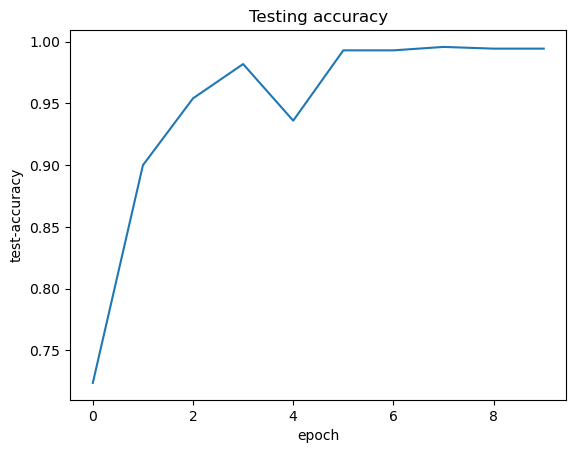

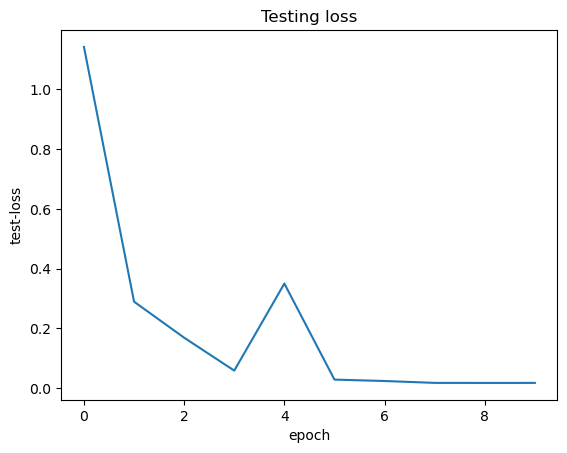

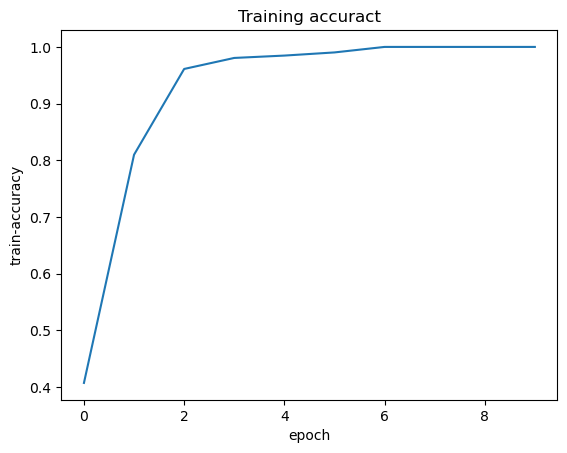

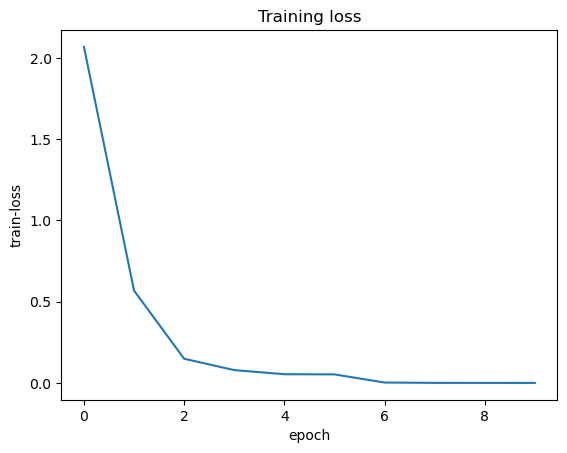

In [4]:
#The training and testing process
class MyNet:
    def __init__(self, args,logger):
        self.args = args
        self.logger = logger
        self.Mymodel = Mymodel().to(args.device)
        self._print_args()

    def _print_args(self):
        self.logger.info('> training arguments:')
        for arg in vars(self.args):
            self.logger.info(f">>> {arg}: {getattr(self.args, arg)}")

    def _train(self, dataloader, criterion, optimizer):
        self.args.index += 1
        train_loss, n_correct, n_train = 0, 0, 0
        # Turn on the train mode
        self.Mymodel.train()
        for inputs, targets in tqdm(dataloader, disable=self.args.backend, ascii='>='):
            inputs, targets = inputs.to(self.args.device), targets.to(self.args.device)
            predicts = self.Mymodel(inputs)
            loss = criterion(predicts, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * targets.size(0)
            n_correct += (torch.argmax(predicts, dim=1) == targets).sum().item()
            n_train += targets.size(0)

        return train_loss / n_train, n_correct / n_train

    def _test(self, dataloader, criterion):
        test_loss, n_correct, n_test = 0, 0, 0
        # Turn on the eval mode
        self.Mymodel.eval()

        with torch.no_grad():
            for inputs, targets in tqdm(dataloader, disable=self.args.backend, ascii=' >='):
                inputs, targets = inputs.to(self.args.device), targets.to(self.args.device)
                predicts = self.Mymodel(inputs)
                loss = criterion(predicts, targets)

                test_loss += loss.item() * targets.size(0)
                n_correct += (torch.argmax(predicts, dim=1) == targets).sum().item()
                n_test += targets.size(0)

        return test_loss / n_test, n_correct / n_test

    def run(self):
        # Print the parameters of model
        for name, layer in self.Mymodel.named_parameters(recurse=True):
            print(name, layer.shape, sep=" ")

        train_dataloader, test_dataloader = load_dataset(self)
        _params = filter(lambda x: x.requires_grad, self.Mymodel.parameters())
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.AdamW(_params, lr=self.args.lr, weight_decay=self.args.weight_decay)

        index = 0
        l_acc, l_trloss, l_epo, l_teloss, l_tracc = [], [], [],[],[]
        # Get the best_loss and the best_acc
        best_loss, best_acc = 0, 0
        for epoch in range(self.args.num_epoch):
            train_loss, train_acc = self._train(train_dataloader, criterion, optimizer)
            test_loss, test_acc = self._test(test_dataloader, criterion)
            l_epo.append(epoch), l_acc.append(test_acc), l_trloss.append(train_loss), l_teloss.append(test_loss), l_tracc.append(train_acc)
            if test_acc > best_acc or (test_acc == best_acc and test_loss < best_loss):
                best_acc, best_loss = test_acc, test_loss
                index = epoch
            self.logger.info(
                '{}/{} - {:.2f}%'.format(epoch + 1, self.args.num_epoch, 100 * (epoch + 1) / self.args.num_epoch))
            self.logger.info('[train] loss: {:.4f}, acc: {:.2f}'.format(train_loss, train_acc * 100))
            self.logger.info('[test] loss: {:.4f}, acc: {:.2f}'.format(test_loss, test_acc * 100))
        self.logger.info(
            'best loss: {:.4f}, best acc: {:.2f}, best index: {:d}'.format(best_loss, best_acc * 100, index))
        self.logger.info('log saved: {}'.format(self.args.log_name))
        # Draw the training process
        plt.figure(1)
        plt.plot(l_epo, l_acc)
        plt.ylabel('test-accuracy')
        plt.xlabel('epoch')
        plt.title("Testing accuracy")
        plt.savefig('./result/' + "My_model" + 'teacc.png')

        plt.figure(2)
        plt.plot(l_epo, l_teloss)
        plt.ylabel('test-loss')
        plt.xlabel('epoch')
        plt.title("Testing loss")
        plt.savefig('./result/' + "My_model" + 'teloss.png')

        plt.figure(3)
        plt.plot(l_epo, l_tracc)
        plt.ylabel('train-accuracy')
        plt.xlabel('epoch')
        plt.title("Training accuract")
        plt.savefig('./result/' + "My_model" + 'tracc.png')

        plt.figure(4)
        plt.plot(l_epo, l_trloss)
        plt.ylabel('train-loss')
        plt.xlabel('epoch')
        plt.title("Training loss")
        plt.savefig('./result/' + "My_model" + 'trloss.png')




if __name__ == '__main__':
    args, logger = get_config()
    net = MyNet(args,logger)  # Initialize MyNet with the provided arguments.
    net.run()  # Start the training and testing process.